<a href="https://colab.research.google.com/github/iniparhan/Human_Fall_Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import os
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

import warnings
warnings.filterwarnings('ignore')
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from pathlib import Path
from tqdm import tqdm

print("\n Library Done!! \n")


 Library Done!! 



## Fungsi - fungsi

In [ ]:
# Fungsi untuk mengecek ukuran gambar
def cek_lebar_tinggi_gambar(directory):

  '''
  Ini fungsi untuk melihat panjang dan lebar pada gambar.
  Baik yang terkecil dan juga terbesar pada direktori
  '''

  width_min = float('inf')
  height_min = float('inf')
  width_max = float('-inf')
  height_max = float('-inf')

  for filename in os.listdir(directory):
      if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
          img_path = os.path.join(directory, filename)
          try:
              img = Image.open(img_path)
              width, height = img.size

              if width < width_min:
                  width_min = width
              if width > width_max:
                  width_max = width

              if height < height_min:
                  height_min = height
              if height > height_max:
                  height_max = height
          except Exception as e:
              print(f"Gagal membaca {filename}: {e}")

  return width_min, width_max, height_min, height_max

In [ ]:
# Cek direktori mana saja yang berisi file berformat gambar
def cek_isi_directory(directory):

  '''
  Ini fungsi untuk melihat direktori mana saja yang berisi file berformat gambar.

  Contoh OUTPUT:
  '/content/drive/MyDrive/Colab Notebooks/Fall Detection/train/subject-3/fall/3_left_falls'

  '''

  direktori_dengan_gambar = []

  for dirpath, dirnames, filenames in os.walk(directory):
      for filename in filenames:
          if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
              direktori_dengan_gambar.append(dirpath)
              break

  return direktori_dengan_gambar

In [ ]:
# Fungsi cek gambar pada setiap class
def show_images_from_dataset_folder(dataset_dir=None, total_per_class=3, title='Sample Images'):

    '''
    Ini fungsi untuk melihat sampel gambar pada setiap class.

    dataset_dir=None,         # Direktori dataset (pastikan direktori berisi langsung menuju banyak class)
    total_per_class=3,        # Mau berapa banyak gambar yang ditampilkan pada setiap class nya?
    title='Sample Images'     # Judul dari gambar yang ditampilkan (terserah wes mau dikasih opo)

    Contoh OUTPUT:
    '/content/drive/MyDrive/Colab Notebooks/Fall Detection/train/subject-3/fall/3_left_falls'

    '''

    if dataset_dir == None:
        return "Tidak Ada Dataset Yang Diberikan"
    else:
        class_folders = sorted(os.listdir(dataset_dir))
        all_image_paths = []
        all_labels = []

        for class_name in class_folders:
            class_path = os.path.join(dataset_dir, class_name)
            if not os.path.isdir(class_path):
                continue  # skip file yang bukan folder

            all_files = os.listdir(class_path)
            # Amankan jika jumlah file lebih sedikit dari permintaan
            sample_files = all_files[:total_per_class] if len(all_files) < total_per_class else \
                           np.random.choice(all_files, total_per_class, replace=False)

            image_paths = [os.path.join(class_path, fname) for fname in sample_files]
            all_image_paths.extend(image_paths)
            all_labels.extend([class_name] * len(image_paths))

        total_classes = len(class_folders)
        total_images = len(all_image_paths)

        # Ukuran figure fleksibel
        plt.figure(figsize=(3 * total_per_class, 3 * total_classes))
        for i, (path, label) in enumerate(zip(all_image_paths, all_labels)):
            plt.subplot(total_classes, total_per_class, i + 1)
            img = Image.open(path).convert('RGB')
            plt.imshow(img)
            plt.title(label, fontsize=9)
            plt.axis('off')

        plt.suptitle(title, fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.93])
        plt.show()

## Data Exploration

In [ ]:
# Cek isi Directory
os.listdir('/content/drive/MyDrive/Colab Notebooks/Fall Detection')

['notebook.ipynb',
 'sample_submission.csv',
 'inference.py',
 'yolov5s.pt',
 'main_tensor-YOLO_version.ipynb',
 'test',
 'train',
 'train_new']

In [ ]:
# Memecah 2 direktori ke 2 variabel
path = '/content/drive/MyDrive/Colab Notebooks/Fall Detection'
train_dir = os.path.join(path, 'train')
test_dir = os.path.join(path, 'test')

In [ ]:
# Just check, "what inside this directory?"
os.listdir(test_dir)

['647dffdb16.jpg',
 '7b87b1c629.jpg',
 '969abf1c80.jpg',
 '8c52c46b21.jpg',
 '99105a2c5d.jpg',
 'a0dcf7a225.jpg',
 '91d93bb89b.jpg',
 '8553d346e6.jpg',
 'ae8c20ce56.jpg',
 'ac5a4a0d8e.jpg',
 'a35f554a4a.jpg',
 '9dc88ff28b.jpg',
 'a271e50f76.jpg',
 '8702671945.jpg',
 '99a1af480f.jpg',
 'a5ad7e5bb5.jpg',
 '8edd082f9a.jpg',
 'a568a78aa6.jpg',
 'b04ae661d8.jpg',
 'a7b8a95868.jpg',
 '938101c730.jpg',
 'ad63a1d363.jpg',
 'a340489240.jpg',
 '9bef05b3ec.jpg',
 'a7432008b7.jpg',
 '97c2632c8e.jpg',
 '8fd8f35995.jpg',
 '8f5a9c7ce9.jpg',
 'a6ec9cfb78.jpg',
 '8cb79fa021.jpg',
 'a8dbd66545.jpg',
 '9acb03bfbc.jpg',
 '85492e3e6d.jpg',
 'aa5863c371.jpg',
 'ac8fe7e8ba.jpg',
 '98650c5640.jpg',
 '98207ad0b4.jpg',
 '9d668b8b02.jpg',
 '9f3f1f0374.jpg',
 '986f497b40.jpg',
 '8c91b3a394.jpg',
 'a6e8a7cf1b.jpg',
 'a69b905720.jpg',
 'a849f04b34.jpg',
 '90ac587a48.jpg',
 '86a9a55bb8.jpg',
 'ac6c7b4272.jpg',
 '92303f2d31.jpg',
 '8c28b7a86b.jpg',
 '8ec04733cd.jpg',
 '9e5defa2c1.jpg',
 '960b0fb619.jpg',
 '86b31415e7

this fine, karena fungsinya untuk validasi test di akhir, dan di catat menggunakan excel

In [ ]:
# Menghasilkan output dari fungsi diatas
lebar_min, lebar_max, tinggi_min, tinggi_max = cek_lebar_tinggi_gambar(test_dir)

print(f'Lebar Gambar Terkecil: {lebar_min} Terbesar: {lebar_max}')
print(f'Tinggi Gambar Terkecil: {tinggi_min} Terbesar: {tinggi_max}')

Lebar Gambar Terkecil: 1280 Terbesar: 1280
Tinggi Gambar Terkecil: 720 Terbesar: 720


In [ ]:
# Cek isi direktori train
os.listdir(train_dir)

['subject-3', 'subject-1', 'subject-2', 'subject-4']

wah, ternyata masih ada folder di dalam folder

In [ ]:
list_train_direktori = cek_isi_directory(train_dir)
list_train = []

for direktori in list_train_direktori:
  for idx, dir in enumerate(direktori.split('/')):
    if dir == 'train':
      direktori = direktori.split('/')[idx+1:]
      list_train.append('/'.join(direktori))

list_train

['subject-3/fall/3_left_falls',
 'subject-3/fall/3_right_falls',
 'subject-3/fall/3_sitting_falls',
 'subject-3/fall/3_backward_falls',
 'subject-3/fall/3_forward_falls',
 'subject-3/fall/3_standing_falls',
 'subject-3/non_fall/3_walking',
 'subject-3/non_fall/3_stretching',
 'subject-3/non_fall/3_laying',
 'subject-3/non_fall/3_picking',
 'subject-3/non_fall/3_jumping',
 'subject-3/non_fall/3_squat',
 'subject-1/non_fall/1_squat',
 'subject-1/non_fall/1_jumping',
 'subject-1/non_fall/1_laying',
 'subject-1/non_fall/1_picking',
 'subject-1/non_fall/1_walking',
 'subject-1/non_fall/1_stretching',
 'subject-1/fall/1_forward_falls',
 'subject-1/fall/1_left_falls',
 'subject-1/fall/1_sitting_falls',
 'subject-1/fall/1_right_falls',
 'subject-1/fall/1_standing_falls',
 'subject-1/fall/1_backward_falls',
 'subject-2/fall/2_right_falls',
 'subject-2/fall/2_left_falls',
 'subject-2/fall/2_backward_falls',
 'subject-2/fall/2_sitting_falls',
 'subject-2/fall/2_forward_falls',
 'subject-2/fall/2_

In [ ]:
# Buat direktori baru yang hanya berisi file fall dan non-fall di dalam direktori train
nama_folder = '/content/drive/MyDrive/Colab Notebooks/Fall Detection/train_new'
os.makedirs(nama_folder, exist_ok=True)

fall_dir = os.path.join(nama_folder, 'fall')
non_fall_dir = os.path.join(nama_folder, 'no_fall')

os.makedirs(fall_dir, exist_ok=True)
os.makedirs(non_fall_dir, exist_ok=True)

In [ ]:
# Copy file ke direktori baru yang hanya berisi file fall dan non-fall di dalam direktori train
for folder in list_train_direktori:
    label = 'fall' if 'fall' in folder.lower().split('/') else 'no_fall'

    # Pilih folder target
    target_dir = fall_dir if label == 'fall' else non_fall_dir

    for file in os.listdir(folder):
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            src_path = os.path.join(folder, file)

            # Tambahkan nama folder sebagai prefix untuk menghindari konflik
            filename = f"{os.path.basename(folder)}_{file}"
            dst_path = os.path.join(target_dir, filename)

            # Cek apakah file sudah ada di tujuan
            if os.path.exists(dst_path):
                # print(f"[SKIP] File sudah ada :{dst_path}")
                print(f"[SKIP]")
                continue

            # Salin file
            shutil.copy2(src_path, dst_path)
            # print(f"[COPY] {src_path} -> {dst_path}")


print("<---- Selesai ---->")

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Fall Detection/train_new'
os.listdir(train_dir)

['fall', 'no_fall']

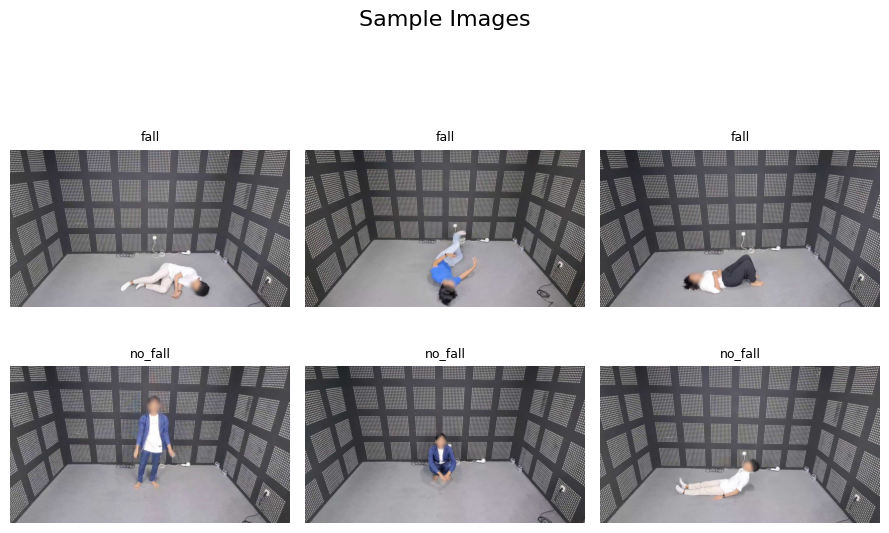

In [ ]:
show_images_from_dataset_folder(dataset_dir=train_dir, total_per_class=3, title='Sample Images')

In [ ]:
lebar_min, lebar_max, tinggi_min, tinggi_max = cek_lebar_tinggi_gambar(os.path.join(train_dir, 'fall'))

print(f'Lebar Gambar Terkecil: {lebar_min} Terbesar: {lebar_max}')
print(f'Tinggi Gambar Terkecil: {tinggi_min} Terbesar: {tinggi_max}')

Gagal membaca 3_forward_falls_frame016.jpg: cannot identify image file '/content/drive/MyDrive/Colab Notebooks/Fall Detection/train_new/fall/3_forward_falls_frame016.jpg'
Lebar Gambar Terkecil: 1280 Terbesar: 1280
Tinggi Gambar Terkecil: 720 Terbesar: 720


### Menentukan Ukuran Gambar

In [ ]:
# Hasil trial and error,

SIZE = 32
# WIDTH = 1280
# HEIGHT = 720
# SIZE = 16

HEIGHT = 224
WIDTH = int(HEIGHT * (1280 / 720))

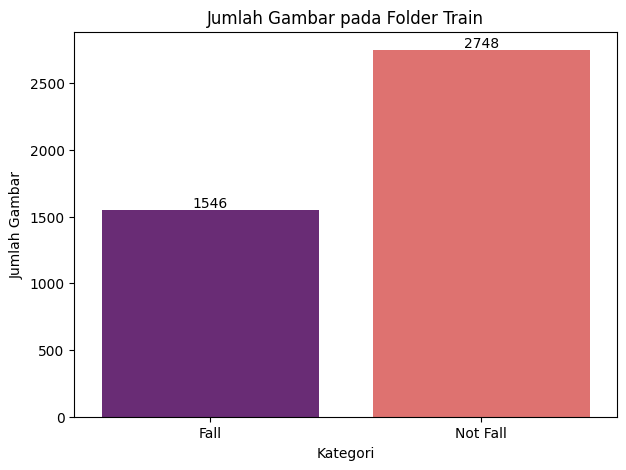

In [ ]:
# Plot untuk melihat proporsi antar class
data_recent_fractured = os.path.join(train_dir, 'fall')
len_data_recent_fractured = len(os.listdir(data_recent_fractured))

data_recent_not_fractured = os.path.join(train_dir, 'no_fall')
len_data_recent_not_fractured = len(os.listdir(data_recent_not_fractured))

plt.figure(figsize=(7, 5))
ax = sns.barplot(x=['Fall', 'Not Fall'], y=[len_data_recent_fractured, len_data_recent_not_fractured], palette='magma')

for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}',
                (p.get_x() + p.get_width() / 2, count),
                ha='center', va='bottom', fontsize=10, fontweight=None)

plt.title(f'Jumlah Gambar pada Folder Train')
plt.xlabel('Kategori')
plt.ylabel('Jumlah Gambar')
plt.show()

In [ ]:
# Fungsi untuk menyalin file ke folder berdasarkan label
def copy_files(file_paths, labels, dest_root):
    for path, label in zip(file_paths, labels):
        label_name = "fall" if label == 1 else "non_fall"
        dest_dir = os.path.join(dest_root, label_name)
        os.makedirs(dest_dir, exist_ok=True)

        dst_path = os.path.join(dest_dir, os.path.basename(path))

        if os.path.exists(dst_path):
            print(f"[SKIP] File sudah ada: {dst_path}")
            continue
        else:
            shutil.copy(path, dst_path)


# Fungsi cek gambar valid
def is_valid_image(path):
    try:
        img = Image.open(path)
        img.verify()
        return True
    except:
        print(f"[RUSAK]: {path}")
        return False

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/Fall Detection/train_new'

fall_dir = os.path.join(train_dir, "fall")
non_fall_dir = os.path.join(train_dir, "no_fall")

fall_files = [os.path.join(fall_dir, f) for f in os.listdir(fall_dir) if f.endswith(".jpg")]
non_fall_files = [os.path.join(non_fall_dir, f) for f in os.listdir(non_fall_dir) if f.endswith(".jpg")]

fall_files = [f for f in fall_files if is_valid_image(f)]
non_fall_files = [f for f in non_fall_files if is_valid_image(f)]

fall_labels = [1] * len(fall_files)
non_fall_labels = [0] * len(non_fall_files)

all_files = fall_files + non_fall_files
all_labels = fall_labels + non_fall_labels

X_train, X_val, y_train, y_val = train_test_split(
    all_files,
    all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

copy_files(X_train, y_train, "dataset_baru/train")
copy_files(X_val, y_val, "dataset_baru/val")


[RUSAK]: /content/drive/MyDrive/Colab Notebooks/Fall Detection/train_new/fall/3_forward_falls_frame016.jpg


## Modelling

In [ ]:
train_dir =  '/content/dataset_baru/train'
val_dir = '/content/dataset_baru/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Fall Detection/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(HEIGHT, WIDTH),
                                                 batch_size=SIZE,
                                                 class_mode='binary',
                                                 color_mode='rgb')

test_set = train_datagen.flow_from_directory(val_dir,
                                             target_size=(HEIGHT, WIDTH),
                                             batch_size=SIZE,
                                             class_mode='binary',
                                             color_mode='rgb')


Found 3434 images belonging to 2 classes.
Found 859 images belonging to 2 classes.


In [ ]:
# Cek class
print(training_set.class_indices)

{'fall': 0, 'non_fall': 1}


In [ ]:
model = Sequential([
    InputLayer(input_shape=(HEIGHT, WIDTH, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),

    # GlobalAveragePooling2D(),
    Flatten(),

    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 396, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 198, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 196, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 96, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 159744)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    20,447,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,540,737 (78.36 MB)

 Trainable params: 20,540,737 (78.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### Model Fit

In [ ]:
history = model.fit(training_set,
                   validation_data=test_set,
                   epochs=10)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 921s 8s/step - accuracy: 0.6305 - loss: 0.9595 - val_accuracy: 0.7544 - val_loss: 0.5809
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 902s 8s/step - accuracy: 0.7150 - loss: 0.5391 - val_accuracy: 0.7485 - val_loss: 0.5399
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 911s 8s/step - accuracy: 0.7847 - loss: 0.4634 - val_accuracy: 0.8522 - val_loss: 0.3362
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 906s 8s/step - accuracy: 0.8424 - loss: 0.3522 - val_accuracy: 0.8580 - val_loss: 0.3356
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 905s 8s/step - accuracy: 0.8712 - loss: 0.2936 - val_accuracy: 0.8754 - val_loss: 0.3057
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 886s 8s/step - accuracy: 0.8729 - loss: 0.3290 - val_accuracy: 0.8754 - val_loss: 0.2836
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 893s 8s/step - accuracy: 0.9100 - loss: 0.2390 - val_accuracy: 0.9057 - val_loss: 0.2214
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 917s 8s/step - accuracy: 0.9311 - loss: 0.1990 - val_accu

In [ ]:
def plot(hist):
  history = hist.history
  history['epoch'] = hist.epoch

  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(history['epoch'], history['loss'], label='Loss')
  plt.plot(history['epoch'], history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(history['epoch'], history['accuracy'], label='Acc')
  plt.plot(history['epoch'], history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

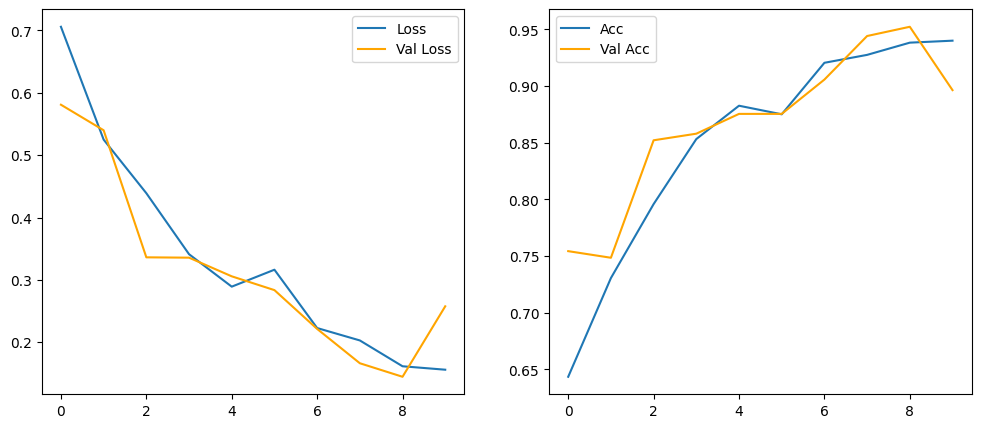

In [ ]:
plot(history)

In [ ]:
model.save('fall_detection.h5')
print('Model Berhasil di Save!!')

Model Berhasil di Save!!


## Evaluate

In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f"Final Test Loss    : {loss:.4f}")
print(f"Final Test Accuracy: {accuracy:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.9255 - loss: 0.2035
Final Test Loss    : 0.2348
Final Test Accuracy: 0.9173


In [ ]:
data_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fall Detection/sample_submission.csv')
data_submission.head()

,id,label
0,4a73abcd02.jpg,0
1,266bdb8d70.jpg,0
2,1389b9fb66.jpg,0
3,7e1c35f2e6.jpg,0
4,8271bebf8f.jpg,0


In [ ]:
labels = []

for data in tqdm(data_submission['id']):
    path = os.path.join(test_dir, data)

    try:
        img = Image.open(path).convert('RGB')
        img = img.resize((WIDTH, HEIGHT))
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array, verbose=0)

        predicted_label = 1 if float(prediction[0]) > 0.5 else 0

        labels.append(predicted_label)

    except Exception as e:
        print(f"Gagal Memproses {data}: {e}")
        labels.append(None)

data_submission['label'] = labels

100%|██████████| 2152/2152 [08:01<00:00,  4.47it/s]


In [ ]:
data_submission.sample(10)

,id,label
102,6ae32c20bf.jpg,0
1000,2a2ef40844.jpg,1
1594,82b19a084b.jpg,1
611,3b8a592619.jpg,0
296,ac2ba4c78f.jpg,1
1709,69d50ed39d.jpg,1
1394,c675a8ed2c.jpg,1
404,b5d23185d5.jpg,1
1370,c3a8c89d1d.jpg,0
2133,617ad0f5d2.jpg,0


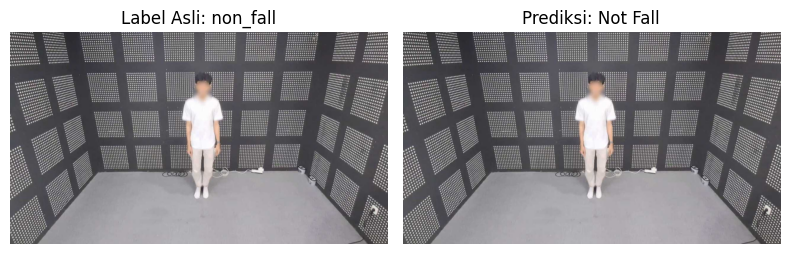

In [ ]:
model = load_model('/content/fall_detection.h5')

random_class = random.choice(os.listdir(train_dir))

class_dir = os.path.join(train_dir, random_class)
random_img_name = random.choice(os.listdir(class_dir))
random_img_path = os.path.join(class_dir, random_img_name)

img = Image.open(random_img_path).convert('RGB')
img_resized = img.resize((WIDTH, HEIGHT))
img_array = np.array(img_resized) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array, verbose=0)
predicted_label =  "Not Fall" if float(prediction[0]) > 0.5 else "Fall"

plt.figure(figsize=(8, 4))

# Gambar asli
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f"Label Asli: {random_class}")
plt.axis('off')

# Gambar hasil prediksi
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title(f"Prediksi: {predicted_label}")
plt.axis('off')

plt.tight_layout()
plt.show()
